In [22]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [23]:
key = os.environ.get('AZURE_SEARCH_KEY', '02f155c1118e41458b879a5937d9e2b5')

In [24]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [25]:
results = search_images_bing(key, 'boats')
ims = results.attrgot('contentUrl')
len(ims)

150

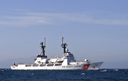

In [26]:
ims = ['https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/US_Navy_080811-G-1103J-584_The_U.S._Coast_Guard_Cutter_USCG_Dallas_%28WHEC_716%29_leaves_Gibraltar.jpg/1200px-US_Navy_080811-G-1103J-584_The_U.S._Coast_Guard_Cutter_USCG_Dallas_%28WHEC_716%29_leaves_Gibraltar.jpg']

dest = 'boat.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

In [33]:
boat_types = 'coast guard cutter','sailboat','cargo ship'
path = Path('boats')

In [28]:
if not path.exists():
    path.mkdir()
    for o in boat_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} boat')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [29]:
fns = get_image_files(path)
fns

(#365) [Path('boats/cargo ship/00000000.jpg'),Path('boats/cargo ship/00000001.jpg'),Path('boats/cargo ship/00000002.jpg'),Path('boats/cargo ship/00000003.jpg'),Path('boats/cargo ship/00000004.jpg'),Path('boats/cargo ship/00000005.jpg'),Path('boats/cargo ship/00000006.jpg'),Path('boats/cargo ship/00000007.jpg'),Path('boats/cargo ship/00000008.jpg'),Path('boats/cargo ship/00000009.jpg')...]

In [30]:
failed = verify_images(fns)
failed

(#0) []

In [31]:
failed.map(Path.unlink);

In [34]:
boats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [35]:
dls = boats.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


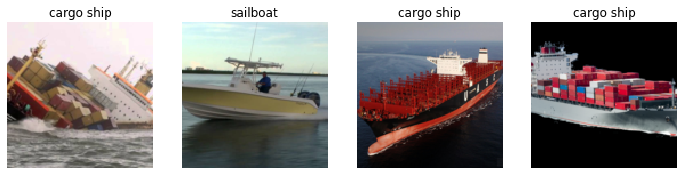

In [37]:
dls.valid.show_batch(max_n=4, nrows=1)

In [39]:
dls = boats.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


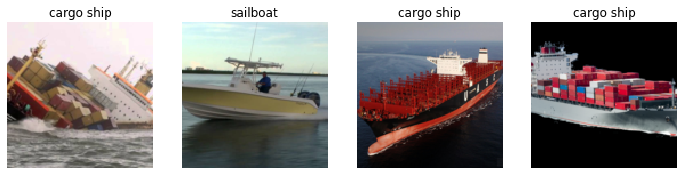

In [40]:
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


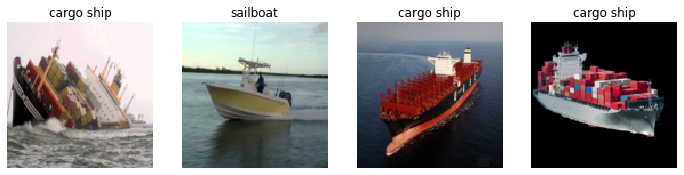

In [42]:
boats = boats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = boats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


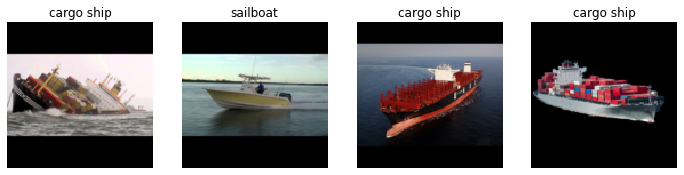

In [43]:
boats = boats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = boats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


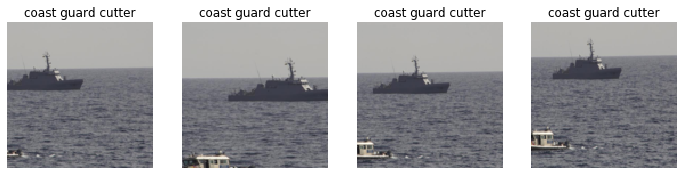

In [44]:
boats = boats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = boats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


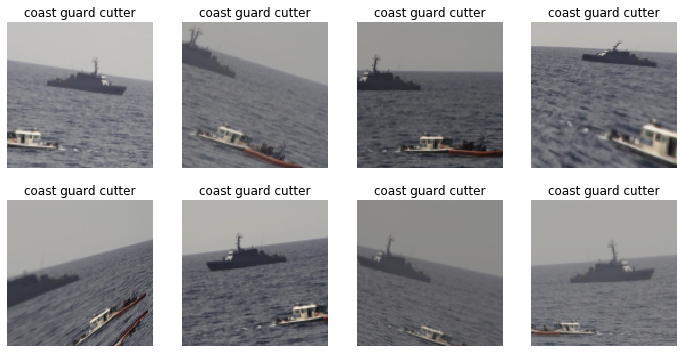

In [45]:
boats = boats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = boats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [46]:
boats = boats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = boats.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [47]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.955490,0.820089,0.315068,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.869502,0.499347,0.191781,00:56
1,0.694744,0.464666,0.136986,00:57
2,0.537951,0.425330,0.123288,01:00
3,0.435455,0.408250,0.136986,01:01


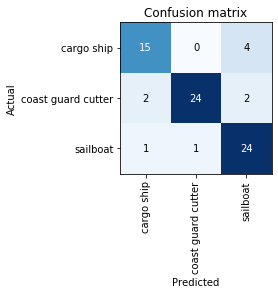

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

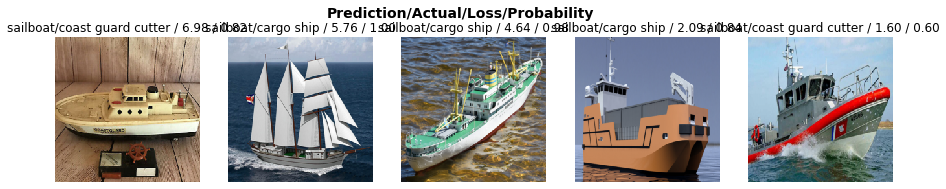

In [49]:
interp.plot_top_losses(5, nrows=1)

In [50]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [76]:
learn.export()

In [77]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [78]:
learn_inf = load_learner(path/'export.pkl')

In [79]:
learn_inf.predict('boat.jpg')

('coast guard cutter', tensor(1), tensor([2.6715e-04, 9.9973e-01, 5.1564e-06]))

In [80]:
learn_inf.dls.vocab

['cargo ship', 'coast guard cutter', 'sailboat']

In [81]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [82]:
img = PILImage.create(btn_upload.data[-1])

In [83]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [84]:
pred,pred_idx,probs = learn_inf.predict(img)

In [85]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: coast guard cutter; Probability: 0.9997')

In [73]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [86]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [87]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [88]:
#hide_output
VBox([widgets.Label('Select your boat!'), 
      btn_upload, btn_run, out_pl, lbl_pred])